## Setting up a classifier with under-sampling, CV and hyperparameter tuning

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=5,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    # we set up the instance hardness threshold
    # with the same classifier that we intend to use in our data
    'iht': InstanceHardnessThreshold(
        estimator=RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=4,
        ),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
# these datasets are baked into imbalanced-learn

datasets_ls = [
    'ecoli',
    'optical_digits',
    'satimage',
    'pen_digits',
    'abalone',
    'sick_euthyroid',
    'spectrometer',
    'car_eval_34',
    'isolet',
    'us_crime',
    'yeast_ml8',
    'scene',
    'libras_move',
    'thyroid_sick',
    'coil_2000',
    'arrhythmia',
    'solar_flare_m0',
    'oil',
    'car_eval_4',
    'wine_quality',
    'letter_img',
    'yeast_me2',
    'webpage',
    'ozone_level',
    'mammography',
    'protein_homo',
    'abalone_19',
]

len(datasets_ls)

27

In [4]:
# print class imbalance of each dataset

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

ecoli
Counter({-1: 301, 1: 35})

optical_digits
Counter({-1: 5066, 1: 554})

satimage
Counter({-1: 5809, 1: 626})

pen_digits
Counter({-1: 9937, 1: 1055})

abalone
Counter({-1: 3786, 1: 391})

sick_euthyroid
Counter({-1: 2870, 1: 293})

spectrometer
Counter({-1: 486, 1: 45})

car_eval_34
Counter({-1: 1594, 1: 134})

isolet
Counter({-1: 7197, 1: 600})

us_crime
Counter({-1: 1844, 1: 150})

yeast_ml8
Counter({-1: 2239, 1: 178})

scene
Counter({-1: 2230, 1: 177})

libras_move
Counter({-1: 336, 1: 24})

thyroid_sick
Counter({-1: 3541, 1: 231})

coil_2000
Counter({-1: 9236, 1: 586})

arrhythmia
Counter({-1: 427, 1: 25})

solar_flare_m0
Counter({-1: 1321, 1: 68})

oil
Counter({-1: 896, 1: 41})

car_eval_4
Counter({-1: 1663, 1: 65})

wine_quality
Counter({-1: 4715, 1: 183})

letter_img
Counter({-1: 19266, 1: 734})

yeast_me2
Counter({-1: 1433, 1: 51})

webpage
Counter({-1: 33799, 1: 981})

ozone_level
Counter({-1: 2463, 1: 73})

mammography
Counter({-1: 10923, 1: 260})

protein_homo
Counter({

In [5]:
# function to train random forests and evaluate the performance
# with hyperparameter optimization

def run_model(X_train, y_train, undersampler=None):

    # set up the classifier
    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3,
    )

    # set up a scaler
    # (as the undersampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()

    # without sampling:
    if not undersampler:

        model = rf

        rf_params = {
            "n_estimators": [10, 50, 100, 500],
            "max_depth": [1, 2, 3, 4],
        }

    # set up a pipeline with sampling:
    else:

        # important to scale before the re-sampler
        # as the many of methods require the variables in
        # a similar scale
        model = Pipeline([
            ("scaler", scaler),
            ("sampler", undersampler),
            ("model", rf),
        ])

        rf_params = {
            "model__n_estimators": [10, 50, 100, 500],
            "model__max_depth": [1, 2, 3, 4],
        }

    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:

    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled

    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data

    search = RandomizedSearchCV(
        model,
        rf_params,
        random_state=0,
        scoring="roc_auc",
    )

    search.fit(X_train, y_train)

    print('Best parameters: {0}, \n Best score: {1}'.format(
        search.best_params_, search.best_score_))

    return search

In [6]:
# now we train several models, with the different under-samplers and
# with cross-validation for each dataset

# to store the results
mean_dict = {}
std_dict = {}


for dataset in datasets_ls:

    # initiate a dictionary per dataset
    mean_dict[dataset] = {}
    std_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,
        data.target,
        test_size=0.3,
        random_state=0,
    )

    # train model on data without re-sampling
    # with cross-validation
    search = run_model(X_train, y_train)

    m, s = pd.DataFrame(search.cv_results_).sort_values(
        by="mean_test_score",
        ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

    # store results
    mean_dict[dataset]['full_data'] = m
    std_dict[dataset]['full_data'] = s

    print()

    for undersampler in undersampler_dict.keys():

        print(undersampler)

        # resample, train and evaluate performance
        # with cross-validation
        search = run_model(X_train, y_train, undersampler_dict[undersampler])

        m, s = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score",
            ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

        # store results
        mean_dict[dataset][undersampler] = m
        std_dict[dataset][undersampler] = s
        print()

    print()

ecoli
Best parameters: {'n_estimators': 50, 'max_depth': 4}, 
 Best score: 0.9220905923344948

random
Best parameters: {'model__n_estimators': 500, 'model__max_depth': 2}, 
 Best score: 0.9100813008130082

cnn
Best parameters: {'model__n_estimators': 10, 'model__max_depth': 3}, 
 Best score: 0.9369802555168409

tomek
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9331823461091755

oss
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 3}, 
 Best score: 0.9320789779326365

enn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.9234146341463415

renn
Best parameters: {'model__n_estimators': 500, 'model__max_depth': 2}, 
 Best score: 0.925993031358885

allknn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9212427409988386

ncr
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9245063879210221

nm1
Best parameters: {'model__n_esti

Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9589594046573854

enn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9671474559973243

renn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9673606756135289

allknn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.9610936912078264

ncr
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9776401605418286

nm1
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8892444291149296

nm2
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 3}, 
 Best score: 0.712845959279234

iht
Best parameters: {'model__n_estimators': 500, 'model__max_depth': 2}, 
 Best score: 0.9552238805970148


car_eval_34
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9853270601765999

random
Best parameters: {'model__n_est

Best parameters: {'model__n_estimators': 10, 'model__max_depth': 2}, 
 Best score: 0.7936613475177305

nm2
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.8981826241134752

iht
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 3}, 
 Best score: 0.9272163120567376


thyroid_sick
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9705097354433636

random
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9702549754631777

cnn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.974974828893037

tomek
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.971046421031696

oss
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9689045339967428

enn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9687240192026627

renn
Best parameters: {'model__n_est

Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8273026651659177

cnn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.82592159207778

tomek
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 2}, 
 Best score: 0.828516781637218

oss
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8213916134887229

enn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8261630701300462

renn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.838465908832001

allknn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.8258647628529643

ncr
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8174358950944667

nm1
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.808609121900628

nm2
Best parameters: {'model__n_

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9641361261495323


yeast_me2
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9374280330222542

random
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9141865577889448

cnn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9015698133524767

tomek
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.9283637832017229

oss
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.9282020818377601

enn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3}, 
 Best score: 0.9263026740847092

renn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9304142139267768

allknn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9295467516152189

ncr
Best parameters: {'model__n

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9364551110953989

ncr
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9356384671132872

nm1
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 1}, 
 Best score: 0.7254423488236439

nm2
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 1}, 
 Best score: 0.7976053064182561

iht
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 1}, 
 Best score: 0.566624440005735


protein_homo
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9660785808010817

random
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9837465640162065

cnn


KeyboardInterrupt: 

The method CNN was running on the `protein_homo` dataset for at least 3 days, so I decided to stop the execution.

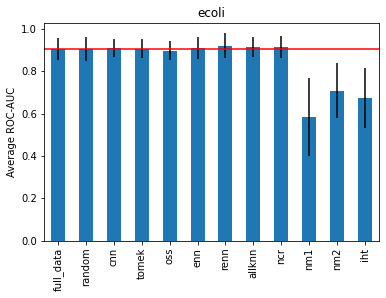

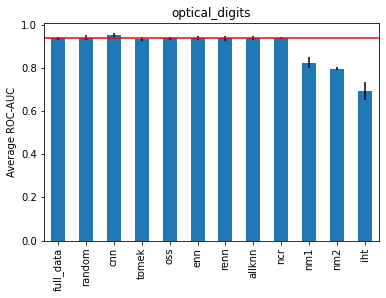

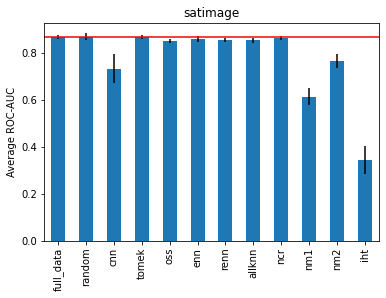

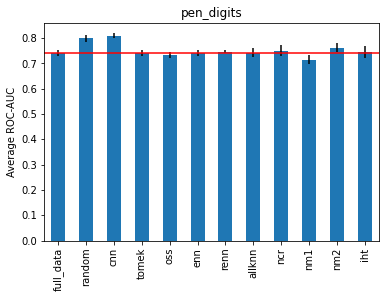

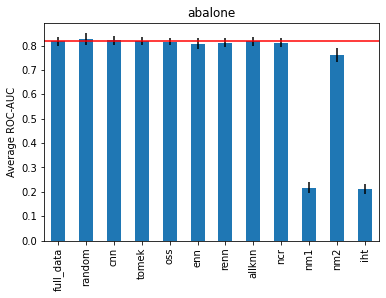

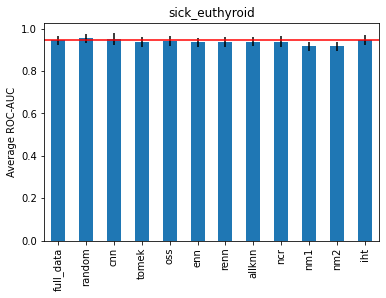

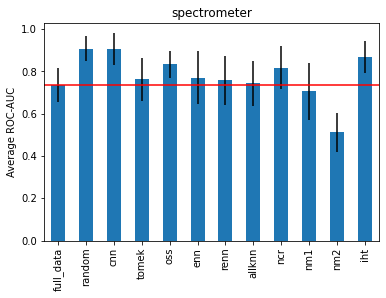

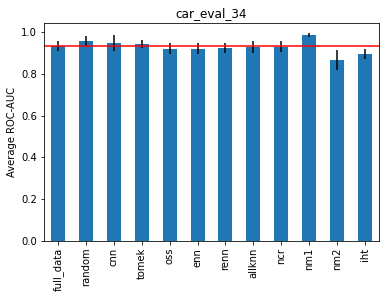

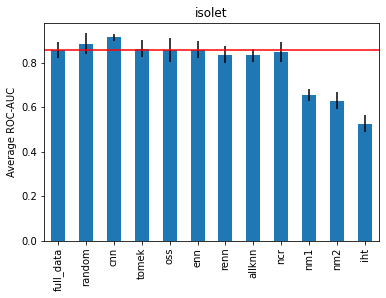

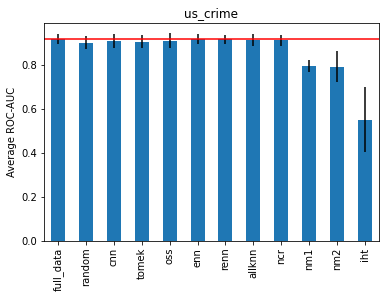

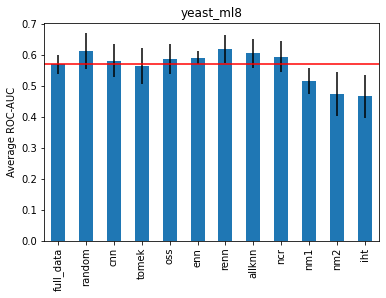

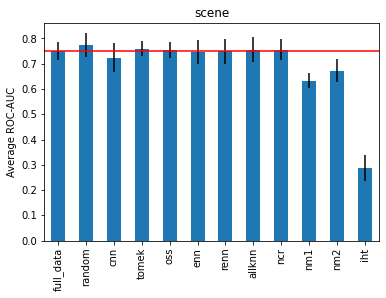

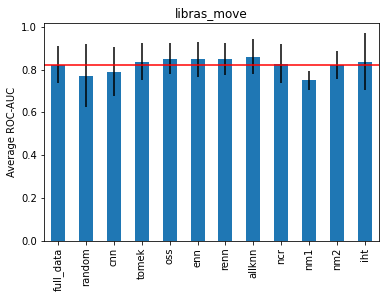

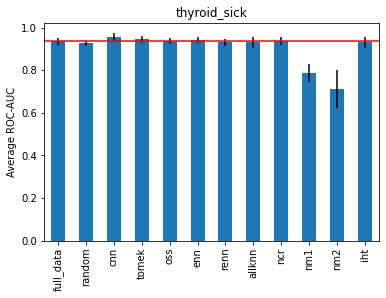

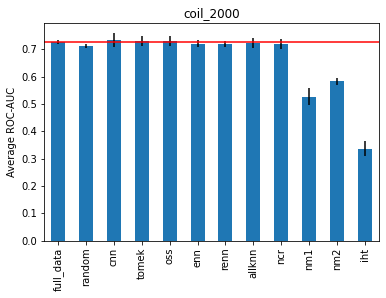

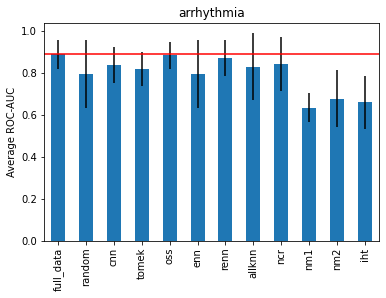

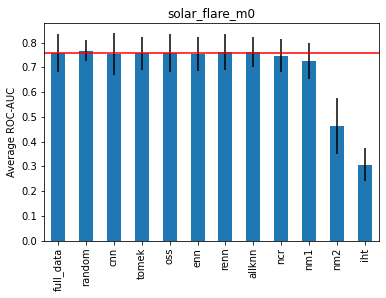

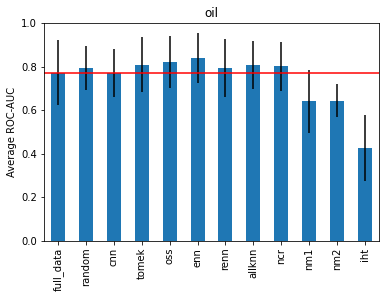

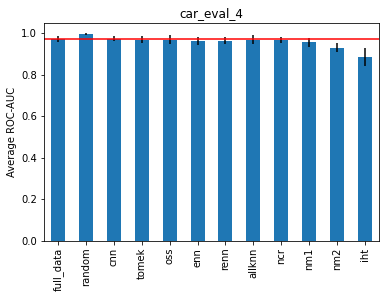

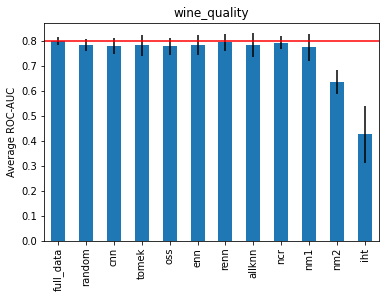

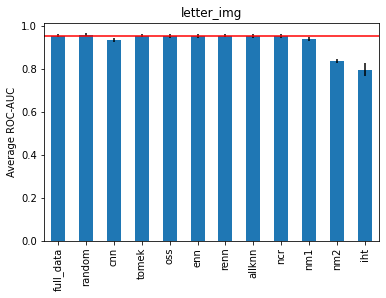

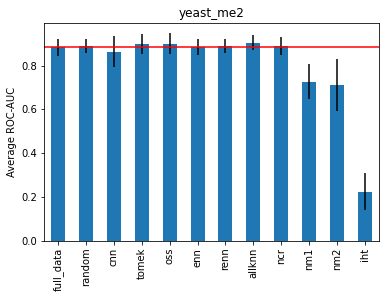

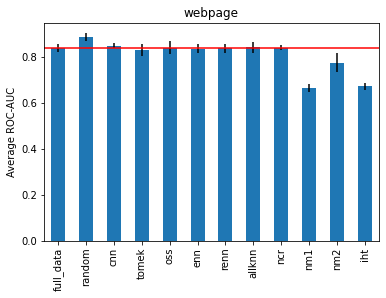

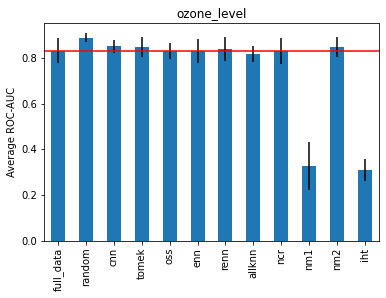

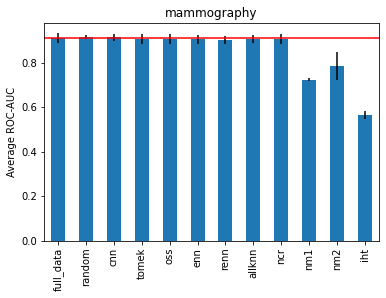

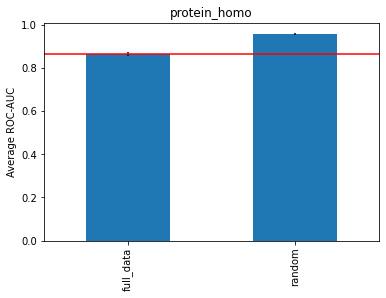

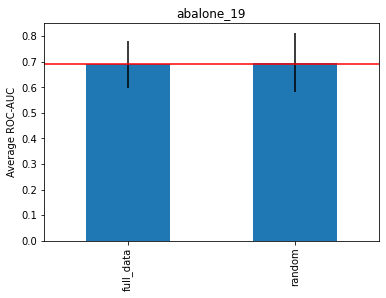

In [10]:
# Now we plot the performance of the model in the 
# left out fold, that was not resampled, from the X_train

for dataset in datasets_ls:
    
    mean_s = pd.Series(mean_dict[dataset])
    std_s = pd.Series(std_dict[dataset])
    
    mean_s.plot.bar(yerr=[std_s, std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average ROC-AUC')
    plt.axhline(mean_dict[dataset]['full_data'], color='r')
    plt.show()

Most undersampling methods were ineffective in terms of improving the performance of random forests.

- Random undersampling improve the performance of random forests in 5 datasets.
- CNN improved the performance of random forests in 3 datasets. We didn't evaluate its performance in the last 2 datasets because it takes ages to run.
- Near miss 1 performance of random forests in 1 datasets.
- The instance hardness threshold performance of random forests in 1 datasets.



In [11]:
import pickle 

with open('us_mean.pkl', 'wb') as f:
    pickle.dump(mean_dict, f)

with open('us_std.pkl', 'wb') as f:
    pickle.dump(std_dict, f)